In [63]:
# Building Micrograd

In [64]:
import math
import numpy as np
import matplotlib.pyplot as plt

## Understanding Derivates

In [65]:
def f(x):
    return 3*x**2 - 4*x + 5

In [66]:
f(3.0)

20.0

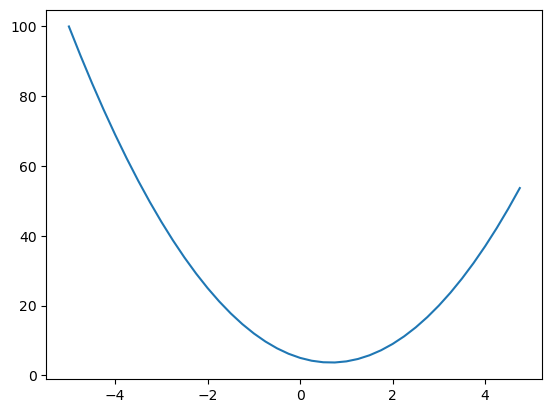

In [67]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs,  ys)

In [68]:
h = 0.0001
x = 3.0
(f(x+h) - f(x)) / h # Derivative using limits

14.000300000063248

In [69]:
# Lets get a bit more complex
h = 0.0001

# Inputs
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
d

4.0

In [70]:
h = 0.0001

# Inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h # a+=h gives you the slope = b and b += h tells you teh slope of d is b. 
# The slope of c wrt d is 1.
d2 = a*b + c

print(f"{d1=}")
print(f"{d2=}")
print(f"Slope = {(d2-d1)/h}")

d1=4.0
d2=4.0001
Slope = 0.9999999999976694


## Lets start building the Value object

In [102]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None # doesn't do anything by default, think leaf nodes
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"

    # In Python, special methods (also known as "magic methods" or "dunder methods") like __mul__ are predefined methods that allow objects to implement and interact with built-in operators. 
    def __add__(self, other): 
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __sub__(self, other): # self - other
        return self + (-other)

    def __rmul__(self, other): # Tries multiplying with the swapped order
        return self * other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*') 
        def _backward():
            self.grad += other.data * out.grad   # Local derivative * global derivative
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __truediv__(self, other): # self / other
        return self * (other**-1)
    
    def __pow__(self, other): # self ** other
        assert isinstance(other, (int, float)), "only supporting int/float powers for now."
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data**(other - 1)) * out.grad
        out._backward = _backward
        return out

    def tanh(self): # Remember, you can implement at various levels of abstraction, we neend't go into exponentiation itself here, we can stick to the level of tanh
        x = self.data
        th = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out =  Value(th, (self,), _op='tanh')
        def _backward():
            self.grad += (1 - th ** 2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    

    def backward(self):
        topo = []
        visited = set()
        def build_topo(node):
            if node not in visited:
                visited.add(node)
                nbrs = node._prev
                for child in nbrs:
                    build_topo(child)
                topo.append(node)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
d = a*b + c
print(f"{d=} , {d._prev=} {d._op=}")
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

d=Value(data=4.0) , d._prev={Value(data=10.0), Value(data=-6.0)} d._op='+'


Value(data=-8.0)

In [72]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    # dot.node(name = uid, label = "{ %s | data %.4f}" % (n.label, n.data), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

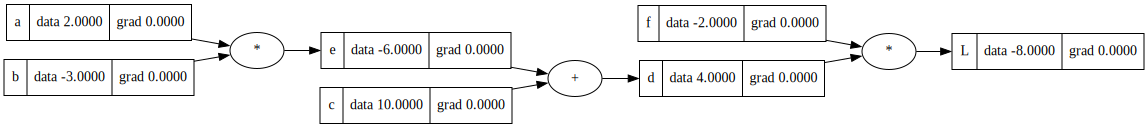

In [73]:
draw_dot(L)

In [74]:
# b.grad = e.grad * a.data
# a.grad = e.grad * b.data

In [75]:
# Single optimization step
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad
a.data += 0.01 * a.grad

# Forward pass
e = a*b
d = e + c
L = d * f

L.data
# -7.286496 from -8 which is better!

-8.0

In [76]:
def lol(): 

    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    e = a * b; e.label = 'e'
    c = Value(10.0, label='c')
    d = c + e; d.label='d'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L1 = L.data
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    e = a * b; e.label = 'e'
    c = Value(10.0, label='c')
    d = c + e; d.label='d'
    d.data += h  # derivative wrt d = -2
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L2 = L.data

    print((L2-L1)/h)
lol()

-2.000000000000668


![Neuron](/Users/karanmatnani/Documents/code/nnKarpathy/kaizzenNnKarpathy/Neuron_image.png)

## Tanh squashes the function to be between -1 and 1.

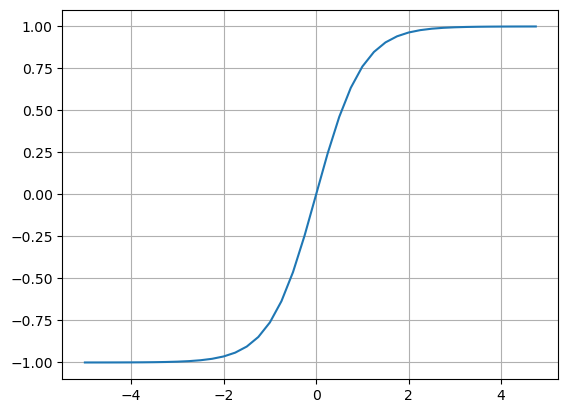

In [77]:
plt.plot(np.arange(-5,5,0.25), np.tanh(np.arange(-5,5,0.25)));plt.grid()

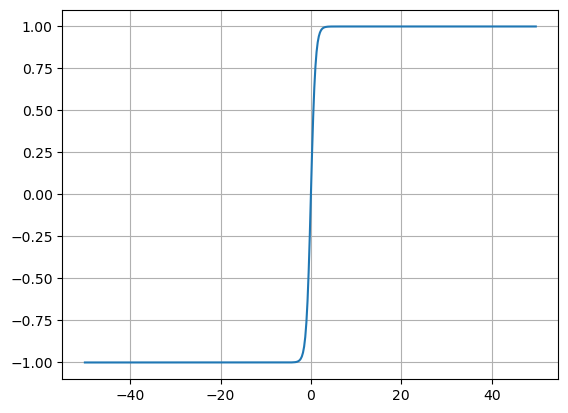

In [78]:

plt.plot(np.arange(-50,50,0.25), np.tanh(np.arange(-50,50,0.25)));plt.grid()


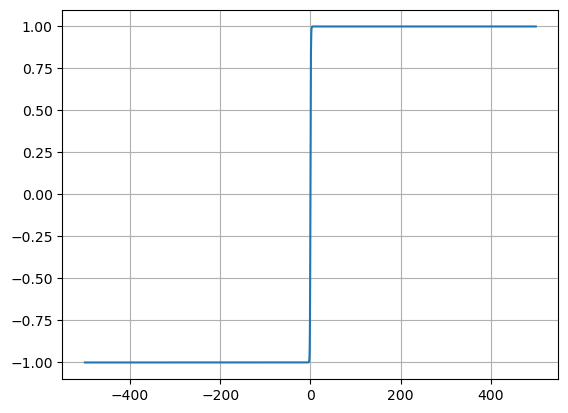

In [79]:
plt.plot(np.arange(-500,500,0.25), np.tanh(np.arange(-500,500,0.25)));plt.grid()

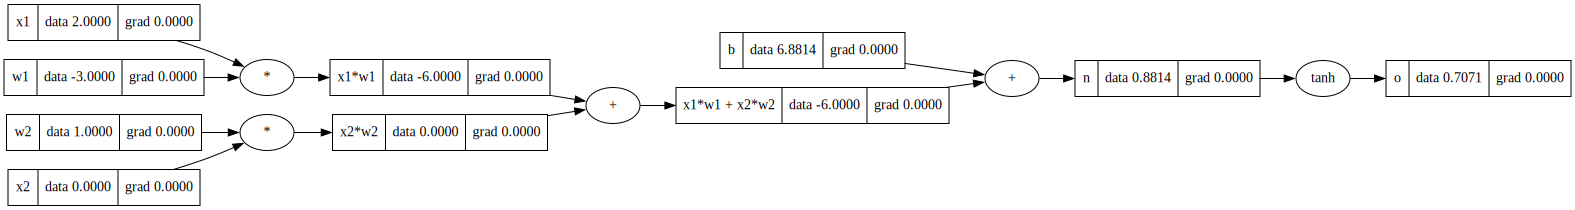

In [80]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
draw_dot(o)

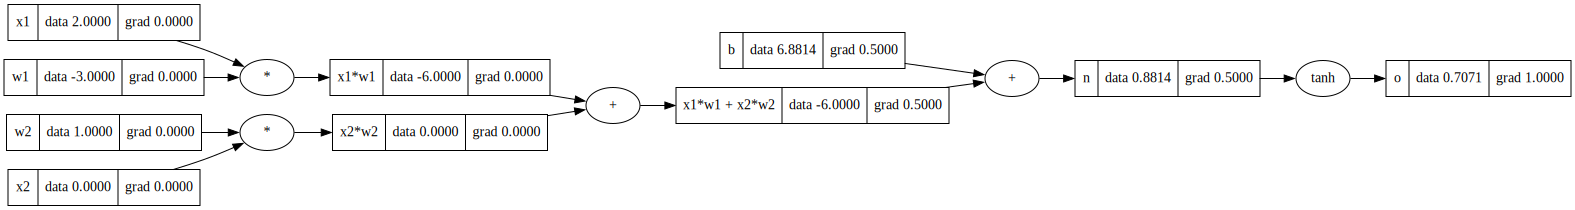

In [81]:
o.grad = 1.0
o._backward()
n._backward()
#... write out all backwards to see the updates. Leaving here to show the mid state.
draw_dot(o)

### Setting gradients
#### NOTE Nugget: 
    + simply routes the gradient to its children.
    * takes the product of the other children, and the gradient.

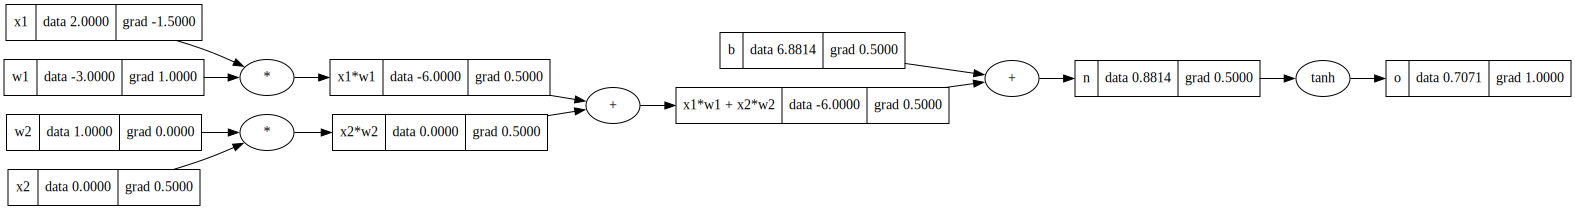

In [82]:

o.grad = 1.0
# o = tanh(n)
# do/dn = (1- tanh(n)**2)
# tanh(n) = o
# do/dn = (1-o**2)
n.grad = 1 - o.data**2
x1w1x2w2.grad = n.grad
b.grad = n.grad
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad
w1.grad = x1.data * x1w1.grad
x1.grad = w1.data * x1w1.grad
w2.grad = x2.data * x2w2.grad
x2.grad = w2.data * x2w2.grad
draw_dot(o)

### Gradient Accumulation.

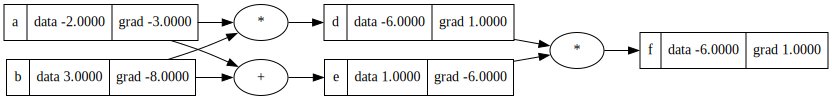

In [85]:
"""
Multi variate calculus shows us that when we take the partial derivative of
one variable wrt another, and we do so multiple times, the right way to 
calculate the net gradient, is to add them all. This is called gradient accumulation here.
"""

a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

### Equivalent of tanh using exponents

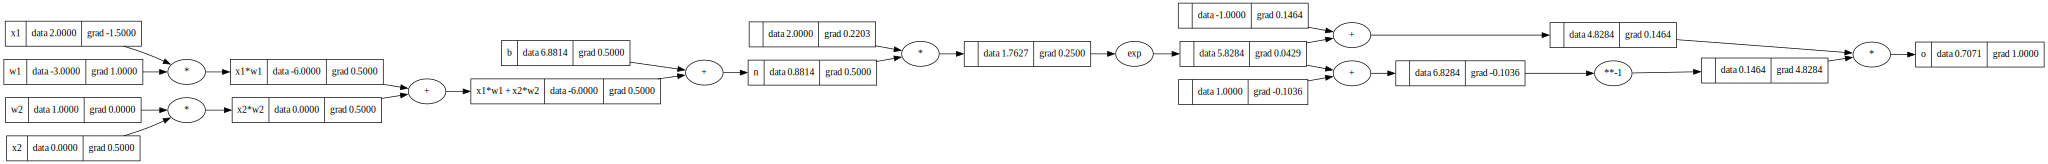

In [89]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ---
e = (2*n).exp()
o = (e-1)/(e+1)
# ---
# o = n.tanh();
o.label = 'o'
o.backward()
draw_dot(o)

## PyTorch Equivalent code for the above expression

In [90]:
import torch
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

/opt/homebrew/Caskroom/miniforge/base/envs/torch_nn_base/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


# Neuron --> Layer --> MLP

In [207]:
import random

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    
    def __call__(self, x): # wx + b
        activation = sum([wi * xi for wi, xi in zip(self.w, x)], self.b)
        out =  activation.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        params = []
        for neuron in self.neurons:
            params.extend(neuron.parameters())
        return params
    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts # Append the input dimension to the list of dimensions 
        # For every pair, generate a layer
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        # Pass a tensor through all layers
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [208]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=0.9600966265879963)

In [209]:
len(n.parameters())

41

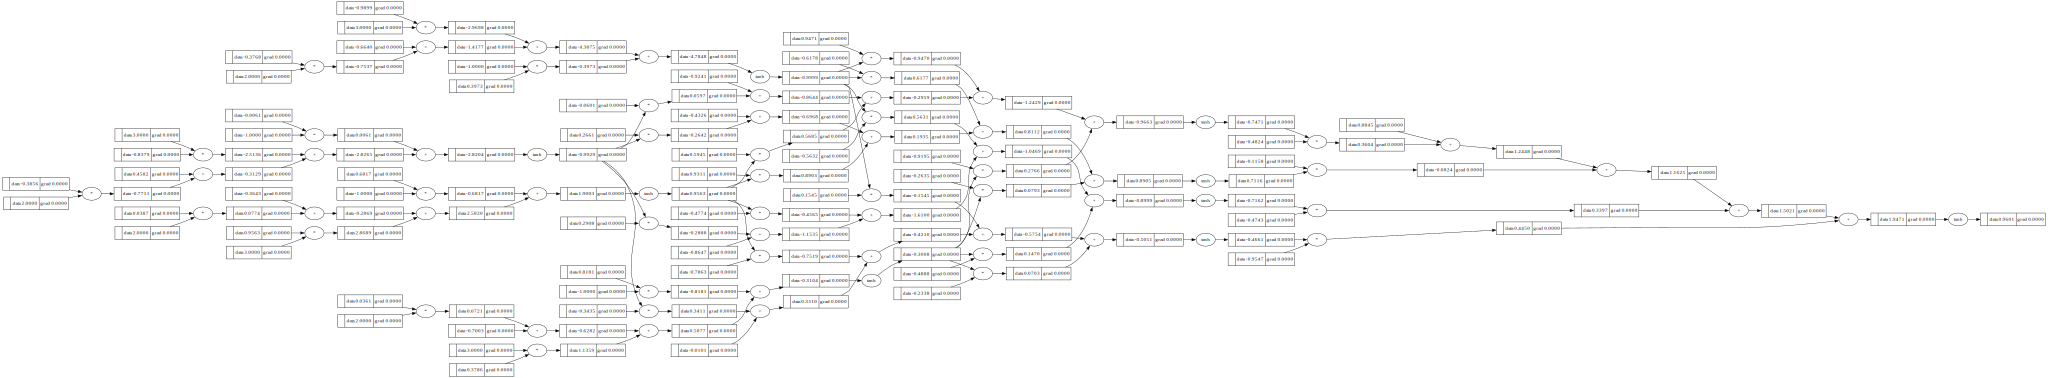

In [210]:
draw_dot(n(x))

In [211]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [212]:
for k in range(20):
    # Forward Pass
    ypred = [n(x) for x in xs]
    loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))
    # Backward pass
    for p in n.parameters(): # NOTE: Zero grad because they keep åccumulating. 
        p.grad = 0.0
    loss.backward()
    # Update
    for p in n.parameters():
        p.data += -0.05 * p.grad
    print(k, loss.data)


0 6.8806214835495405
1 5.883965737569202
2 5.076387488544033
3 4.675471096413794
4 4.387532537183109
5 4.220677542883529
6 4.1242977347046
7 4.063318498651579
8 4.02041254713693
9 3.9870109929822783
10 3.9584592231240334
11 3.9318683229212827
12 3.9051047573866473
13 3.876227427854327
14 3.843062223829011
15 3.8027281602632037
16 3.7509238909159817
17 3.6806740136406764
18 3.580026399597963
19 3.428223856589107
